In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt
import pdb
import sys
sys.path.insert(1, '../mhCompTiss/')
sys.path.insert(2, '../scCompare/scVAE_ABC/workflow/scripts/')

import FuncVAEABC as tr
import scanpyHelpers as scH

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, dpi_save=300, facecolor='white', format="svg", transparent=True)

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


In [6]:
writeDir = "write"
tissue = "pdac"

dictLab = ["species","adataName"]
dataDicts = {"hum":dict(zip(dictLab, ["human",f'{writeDir}/{tissue}PdxMrtx'])),
             "mou":dict(zip(dictLab, ["mouse",f'{writeDir}/{tissue}MouseMrtx']))
             }

mergedAdataFileQC = f'{writeDir}/{tissue}MousePdxMrtx_QC.h5ad'
mergedAdataFile = f'{writeDir}/{tissue}MousePdxMrtx.h5ad'

homologyFile = "data/hgncHM_121.csv"

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


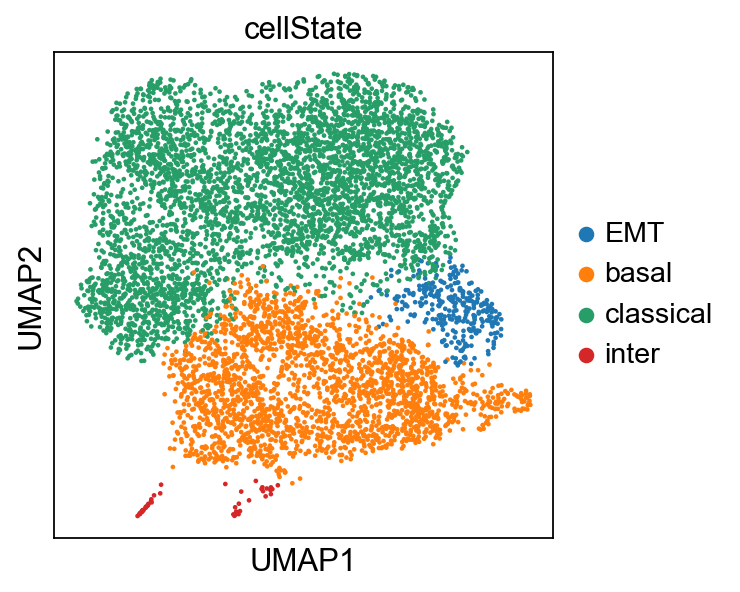

In [7]:
adata = sc.read(dataDicts["mou"]["adataName"]+".h5ad")
sc.pl.umap(adata, color=["cellState"],wspace=0.5)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


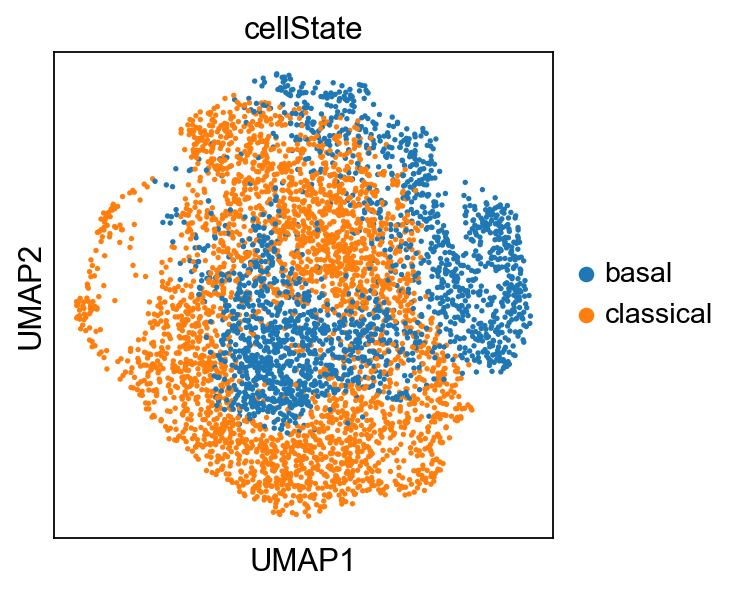

In [8]:
adata = sc.read(dataDicts["hum"]["adataName"]+".h5ad")
sc.pl.umap(adata, color=["cellState"])

In [9]:
homology = pd.read_table(homologyFile, sep=",")
homology

mouse    human
0         A1bg     A1BG
1         A1cf     A1CF
2          A2m      A2M
3      A3galt2  A3GALT2
4       A4galt   A4GALT
...        ...      ...
17271   Zyg11a   ZYG11A
17272   Zyg11b   ZYG11B
17273      Zyx      ZYX
17274    Zzef1    ZZEF1
17275     Zzz3     ZZZ3

[17276 rows x 2 columns]

In [10]:
def getAdata(adataFile, neededObs):
    adata = sc.read(adataFile+"_QC.h5ad")
    adataPost = sc.read(adataFile+".h5ad")
    #pdb.set_trace()
    adata = adata[adataPost.obs_names,:]
    adata.obs[neededObs] = adataPost.obs[neededObs]
    adata.layers["counts"] = adata.X.copy()
    #adata.obs["sample"] = adata.obs["Classification"].copy()
    return(adata)

def getNormAdata(adataFile, neededObs):
    adata = getAdata(adataFile, neededObs)
    sc.pp.normalize_total(adata, target_sum=1e4)#,exclude_highly_expressed=True)#
    sc.pp.log1p(adata)
    return adata

In [11]:
geneSpecDict = []
adatas = []
for datakey in dataDicts.keys():
    print(datakey)
    adata = getNormAdata(dataDicts[datakey]["adataName"], ["cellState","decoupler"])
    geneSpecDict.append({"genes":np.array(adata.var_names.copy()),"species":dataDicts[datakey]["species"]})
    adatas.append(adata)

geneSpecDict

hum
normalizing counts per cell
    finished (0:00:00)


/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_92421/2919780292.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[neededObs] = adataPost.obs[neededObs]


mou
normalizing counts per cell


/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_92421/2919780292.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[neededObs] = adataPost.obs[neededObs]


    finished (0:00:00)


[{'genes': array(['A1CF', 'A2M', 'A2M-AS1', ..., 'ZYG11B', 'ZYX', 'ZZEF1'],
        dtype=object),
  'species': 'human'},
 {'genes': array(['Xkr4', 'Gm1992', 'Gm19938', ..., 'Tmlhe', 'CAAA01147332.1',
         'AC149090.1'], dtype=object),
  'species': 'mouse'}]

In [12]:
scH.getOverlapGenesMulti(homology, geneSpecDict)

[{'genes': array(['A1cf/A1CF', 'A2m/A2M', 'A2M-AS1', ..., 'Zyg11b/ZYG11B', 'Zyx/ZYX',
         'Zzef1/ZZEF1'], dtype=object),
  'species': 'human'},
 {'genes': array(['Xkr4/XKR4', 'Gm1992', 'Gm19938', ..., 'Tmlhe/TMLHE',
         'CAAA01147332.1', 'AC149090.1'], dtype=object),
  'species': 'mouse'}]

In [13]:
for i,genesDict in enumerate(geneSpecDict):
    adatas[i].var_names = genesDict["genes"]

In [14]:
dataDicts.keys()

dict_keys(['hum', 'mou'])

In [15]:
adata = ad.concat(adatas, join="outer", label="dataset", keys=dataDicts.keys(), fill_value=0)
adata.obs_names_make_unique()

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [16]:
adata

AnnData object with n_obs × n_vars = 11879 × 26890
    obs: 'MRTX1_B0251', 'MRTX2_B0252', 'MRTX3_B0253', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mm', 'pct_counts_mm', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'GMM', 'Vehicle1_B0254', 'Vehicle2_B0255', 'Vehicle3_B0256', 'treatment', 'cellState', 'decoupler', 'BFP', 'CLuc', 'CreER', 'DTR', 'EGFP', 'GLuc', 'luciferase', 'mScarlet', 'tdTomato', 'dataset'
    layers: 'counts'

In [17]:
adata.var

Empty DataFrame
Columns: []
Index: [0610005C13Rik, 0610009B22Rik, 0610009E02Rik, 0610009L18Rik, 0610010F05Rik, 0610010K14Rik/C17orf49, 0610012G03Rik, 0610030E20Rik/C2orf68, 0610038B21Rik, 0610039K10Rik, 0610040B10Rik, 0610040F04Rik, 0610040J01Rik/C4orf19, 0610043K17Rik, 0710001A04Rik, 1010001B22Rik, 1010001N08Rik, 1110002L01Rik, 1110004F10Rik/C11orf58, 1110006O24Rik, 1110008P14Rik, 1110012L19Rik, 1110013H19Rik, 1110017D15Rik/C9orf24, 1110018N20Rik, 1110019D14Rik, 1110020A21Rik, 1110028F11Rik, 1110032A03Rik/C11orf1, 1110035H17Rik, 1110038B12Rik, 1110038F14Rik/C8orf33, 1110046J04Rik, 1110051M20Rik/C11orf49, 1110059E24Rik/C9orf85, 1110059G10Rik/KIAA1143, 1110065P20Rik/C1orf122, 1190005I06Rik/C16orf74, 1190007I07Rik/C12orf73, 1200007C13Rik, 1300002E11Rik, 1300014J16Rik, 1300017J02Rik, 1500002C15Rik, 1500002F19Rik, 1500004A13Rik, 1500009C09Rik, 1500009L16Rik/C12orf75, 1500011B03Rik, 1500015A07Rik, 1500015L24Rik, 1500026H17Rik, 1500035N22Rik, 1600002D24Rik, 1600002K03Rik, 1600010M07Rik, 1600012H06Rik/C6orf120, 1600014C10Rik/C19orf12, 1600014C23Rik, 1600020E01Rik, 1700001C19Rik, 1700001D01Rik, 1700001G11Rik, 1700001K19Rik, 1700001L05Rik, 1700001L19Rik/C5orf49, 1700001O22Rik/C9orf50, 1700001P01Rik/C17orf98, 1700003D09Rik, 1700003E16Rik/C2orf81, 1700003F12Rik/C20orf144, 1700003G18Rik, 1700006J14Rik, 1700007J10Rik, 1700007K13Rik/PIERCE1, 1700007L15Rik, 1700008J07Rik, 1700008O03Rik/C19orf81, 1700010I14Rik/C6orf118, 1700010K24Rik, 1700011L22Rik/C4orf51, 1700012B09Rik/C11orf97, 1700012C14Rik, 1700012D14Rik, 1700015F17Rik, 1700016C15Rik/C1orf100, 1700016D06Rik, 1700016H13Rik/C4orf36, 1700016K19Rik/C17orf97, 1700016L21Rik, 1700016P03Rik, 1700017B05Rik/C15orf39, 1700017N19Rik/C12orf50, 1700018A04Rik, 1700018B08Rik/C16orf95, 1700018L02Rik, 1700019D03Rik/C2orf88, 1700019L13Rik, 1700020G17Rik, 1700020L24Rik/C17orf50, ...]

[26890 rows x 0 columns]

In [18]:
adata.obs.iloc[:,35:40]

tdTomato dataset
AAACCCAGTACAGCGA-1-mrtx       NaN     hum
AAACCCAGTTCCTTGC-1-mrtx       NaN     hum
AAACGAACACTGAATC-1-mrtx       NaN     hum
AAACGAACAGGATGAC-1-mrtx       NaN     hum
AAACGCTAGTAGAGTT-1-mrtx       NaN     hum
...                           ...     ...
TTTGGAGTCAGAGCAG-1-veh        0.0     mou
TTTGGTTCATAGAATG-1-veh        0.0     mou
TTTGTTGAGGGCCAAT-1-veh        0.0     mou
TTTGTTGAGTGTAGAT-1-veh        0.0     mou
TTTGTTGGTCATGACT-1-veh        0.0     mou

[11879 rows x 2 columns]

In [19]:
adata.obs["species"] = ["mouse" if lab=="mou" else "human" for lab in adata.obs.dataset]
adata.obs = adata.obs[["species",'GMM',"treatment","cellState","decoupler"]]

In [20]:
mergedAdataFileQC

'write/pdacMousePdxMrtx_QC.h5ad'

In [21]:
adata.write(mergedAdataFileQC)

In [22]:
adata

AnnData object with n_obs × n_vars = 11879 × 26890
    obs: 'species', 'GMM', 'treatment', 'cellState', 'decoupler'
    layers: 'counts'

In [23]:
batchKey = "species"
cellTypeKey = "cellState"

In [24]:
sc.pp.highly_variable_genes(adata, batch_key=batchKey)

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
2172
819


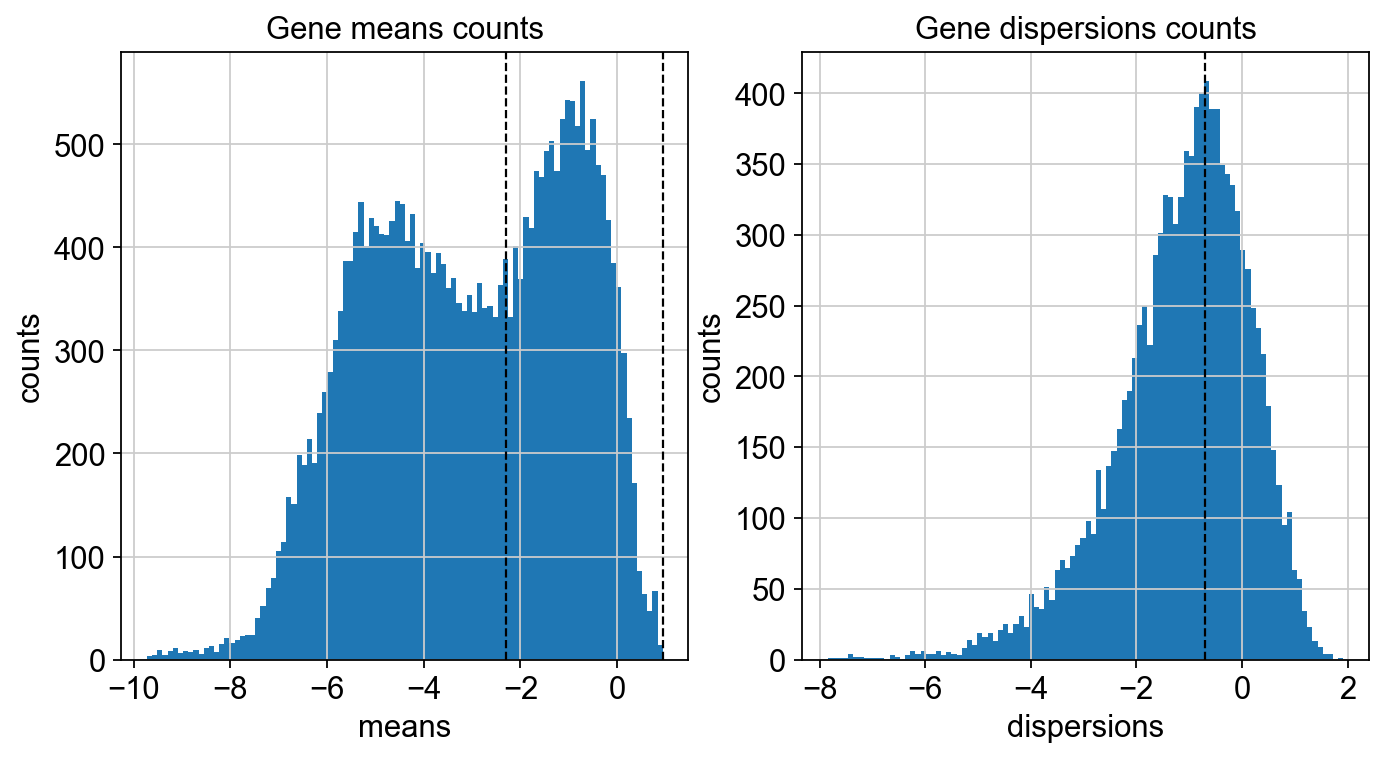

In [25]:
minMean = 0.1
maxMean = 2.6
minDisp = 0.5

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

means = adata.var[["means"]][adata.var[["means"]] > np.exp(-14)]#adata.var[["means"]],
axs[0].hist(np.log(means), bins=100)#, log=True),
axs[0].axvline(np.log(minMean), color='k', linestyle='dashed', linewidth=1)
axs[0].axvline(np.log(maxMean), color='k', linestyle='dashed', linewidth=1)
axs[0].set_title('Gene means counts')
axs[0].set_xlabel('means')
axs[0].set_ylabel('counts')

dispNorm = adata.var[["dispersions_norm"]][adata.var[["dispersions_norm"]] > np.exp(-8)]#adata.var[["means"]],
axs[1].hist(np.log(dispNorm), bins=100)#, log=True),
axs[1].axvline(np.log(minDisp), color='k', linestyle='dashed', linewidth=1)
axs[1].set_title('Gene dispersions counts')
axs[1].set_xlabel('dispersions')
axs[1].set_ylabel('counts')

sc.pp.highly_variable_genes(adata, min_disp=minDisp, min_mean=minMean, max_mean=maxMean, batch_key=batchKey)
print(sum(adata.var.highly_variable))
print(sum(adata.var.highly_variable_intersection))

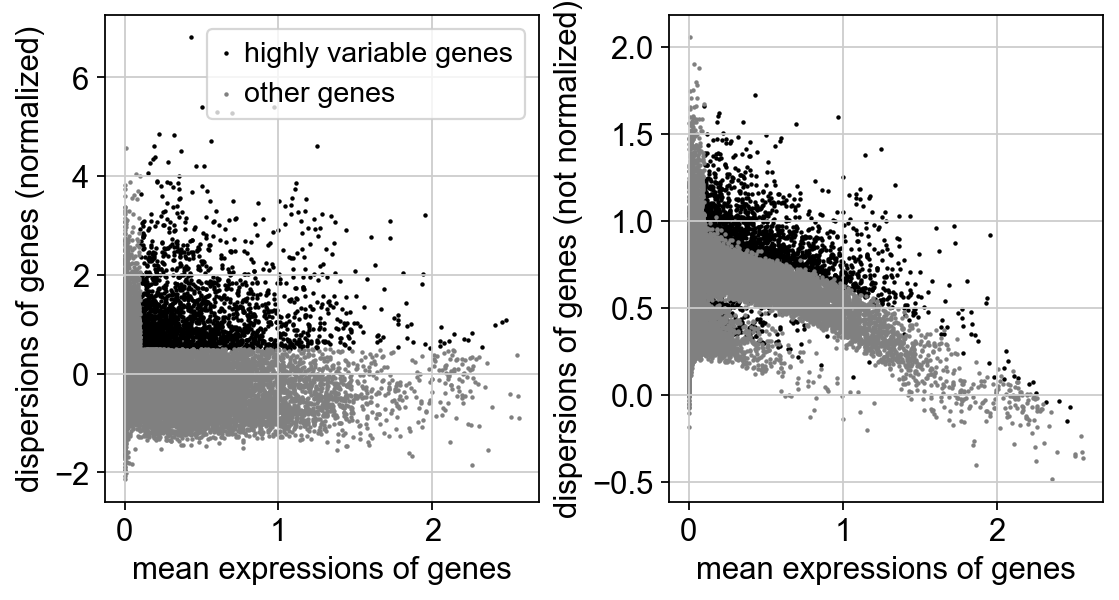

In [26]:
sc.pl.highly_variable_genes(adata)

In [27]:
adata.var[adata.var.highly_variable]

highly_variable     means  dispersions  \
0610040J01Rik/C4orf19             True  0.942500     0.676413   
1500015L24Rik                     True  0.334767     0.653387   
1600010M07Rik                     True  0.330277     0.554146   
1700025G04Rik/C1orf21             True  0.497052     0.876352   
1700029J07Rik/C4orf47             True  0.108952     1.005616   
...                                ...       ...          ...   
Zswim4/ZSWIM4                     True  0.429073     0.906500   
Zswim6/ZSWIM6                     True  1.491028     0.565756   
Zswim8/ZSWIM8                     True  0.375312     0.852353   
Zup1/ZUP1                         True  0.281605     0.833053   
mt-Nd6/MT-ND6                     True  0.904594     0.698841   

                       dispersions_norm  highly_variable_nbatches  \
0610040J01Rik/C4orf19          0.699776                         1   
1500015L24Rik                  1.557348                         1   
1600010M07Rik                  0.967193                         1   
1700025G04Rik/C1orf21          1.103215                         2   
1700029J07Rik/C4orf47          0.992970                         1   
...                                 ...                       ...   
Zswim4/ZSWIM4                  1.307708                         2   
Zswim6/ZSWIM6                  1.015789                         2   
Zswim8/ZSWIM8                  0.847544                         2   
Zup1/ZUP1                      0.529589                         1   
mt-Nd6/MT-ND6                  0.654865                         2   

                       highly_variable_intersection  
0610040J01Rik/C4orf19                         False  
1500015L24Rik                                 False  
1600010M07Rik                                 False  
1700025G04Rik/C1orf21                          True  
1700029J07Rik/C4orf47                         False  
...                                             ...  
Zswim4/ZSWIM4                                  True  
Zswim6/ZSWIM6                                  True  
Zswim8/ZSWIM8                                  True  
Zup1/ZUP1                                     False  
mt-Nd6/MT-ND6                                  True  

[2172 rows x 6 columns]

In [28]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') 

In [29]:
adata.raw = adata

In [30]:
#adata = adata[:, adata.var.highly_variable]
adata = adata[:, np.logical_and(adata.var.highly_variable, np.logical_not(adata.var.mt))]

In [31]:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

In [32]:
#sc.pp.scale(adata, max_value=5)

In [33]:
sc.tl.pca(adata, n_comps = 100, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=100
    finished (0:00:04)


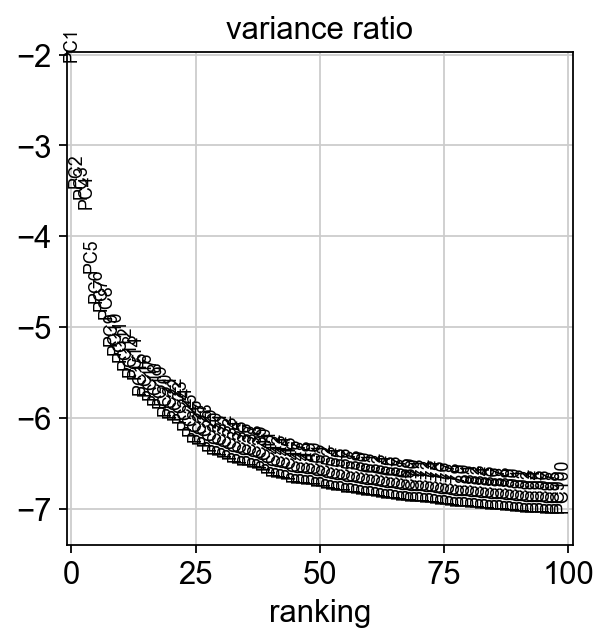

In [34]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100, log=True)

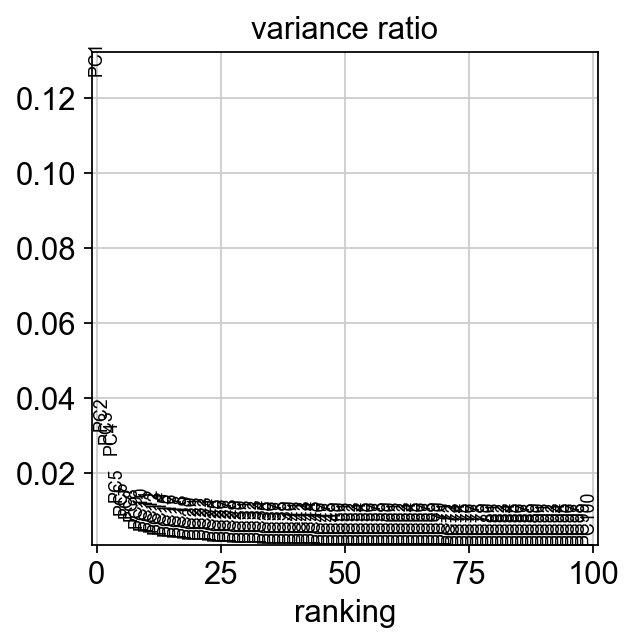

In [35]:
sc.pl.pca_variance_ratio(adata, n_pcs = 100)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


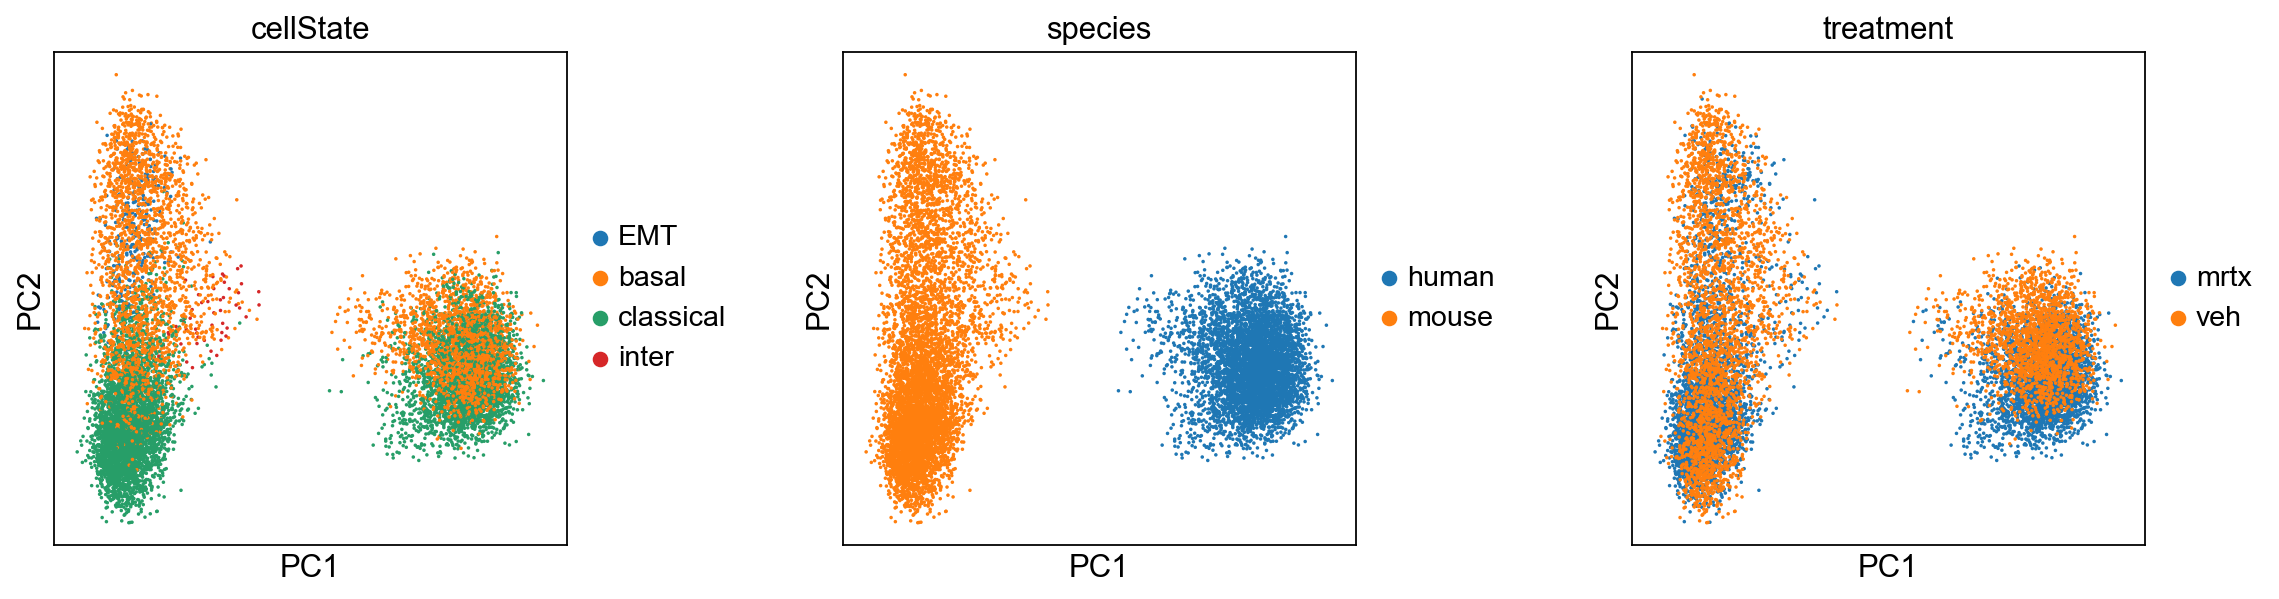

In [38]:
sc.pl.pca(adata, color=[cellTypeKey,batchKey,"treatment"],wspace=0.4)

In [39]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=60)

computing neighbors
    using 'X_pca' with n_pcs = 60
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:00)


In [40]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [41]:
sc.tl.leiden(adata, resolution=0.2, key_added="PCA")

running Leiden clustering
    finished: found 4 clusters and added
    'PCA', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


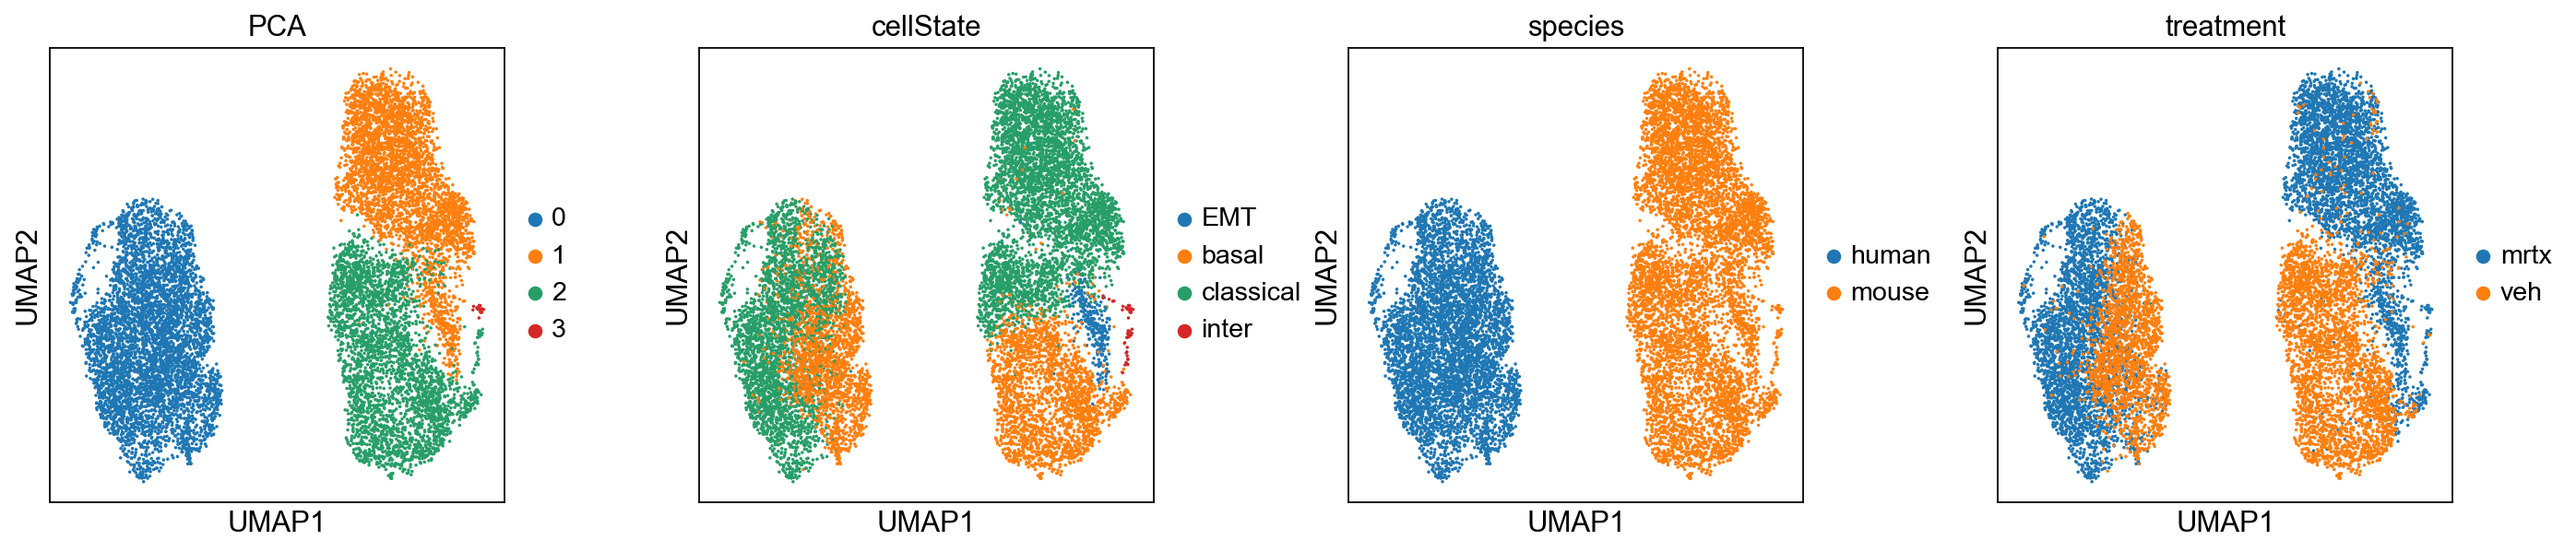

In [43]:
sc.pl.umap(adata, color=["PCA",cellTypeKey,batchKey,"treatment"],ncols=4,wspace=0.3)

In [44]:
adata

AnnData object with n_obs × n_vars = 11879 × 2171
    obs: 'species', 'GMM', 'treatment', 'cellState', 'decoupler', 'PCA'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'hvg', 'pca', 'cellState_colors', 'species_colors', 'treatment_colors', 'neighbors', 'umap', 'leiden', 'PCA_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [45]:
mergedAdataFile

'write/pdacMousePdxMrtx.h5ad'

In [46]:
adata.write(mergedAdataFile)

In [71]:
adata = sc.read(mergedAdataFile)
adata

AnnData object with n_obs × n_vars = 11879 × 2171
    obs: 'species', 'GMM', 'treatment', 'cellState', 'decoupler', 'PCA'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'PCA_colors', 'cellState_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'species_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

computing neighbors
    finished: added to `.uns['norm']`
    `.obsp['norm_distances']`, distances for each pair of neighbors
    `.obsp['norm_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 4 clusters and added
    'norm', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


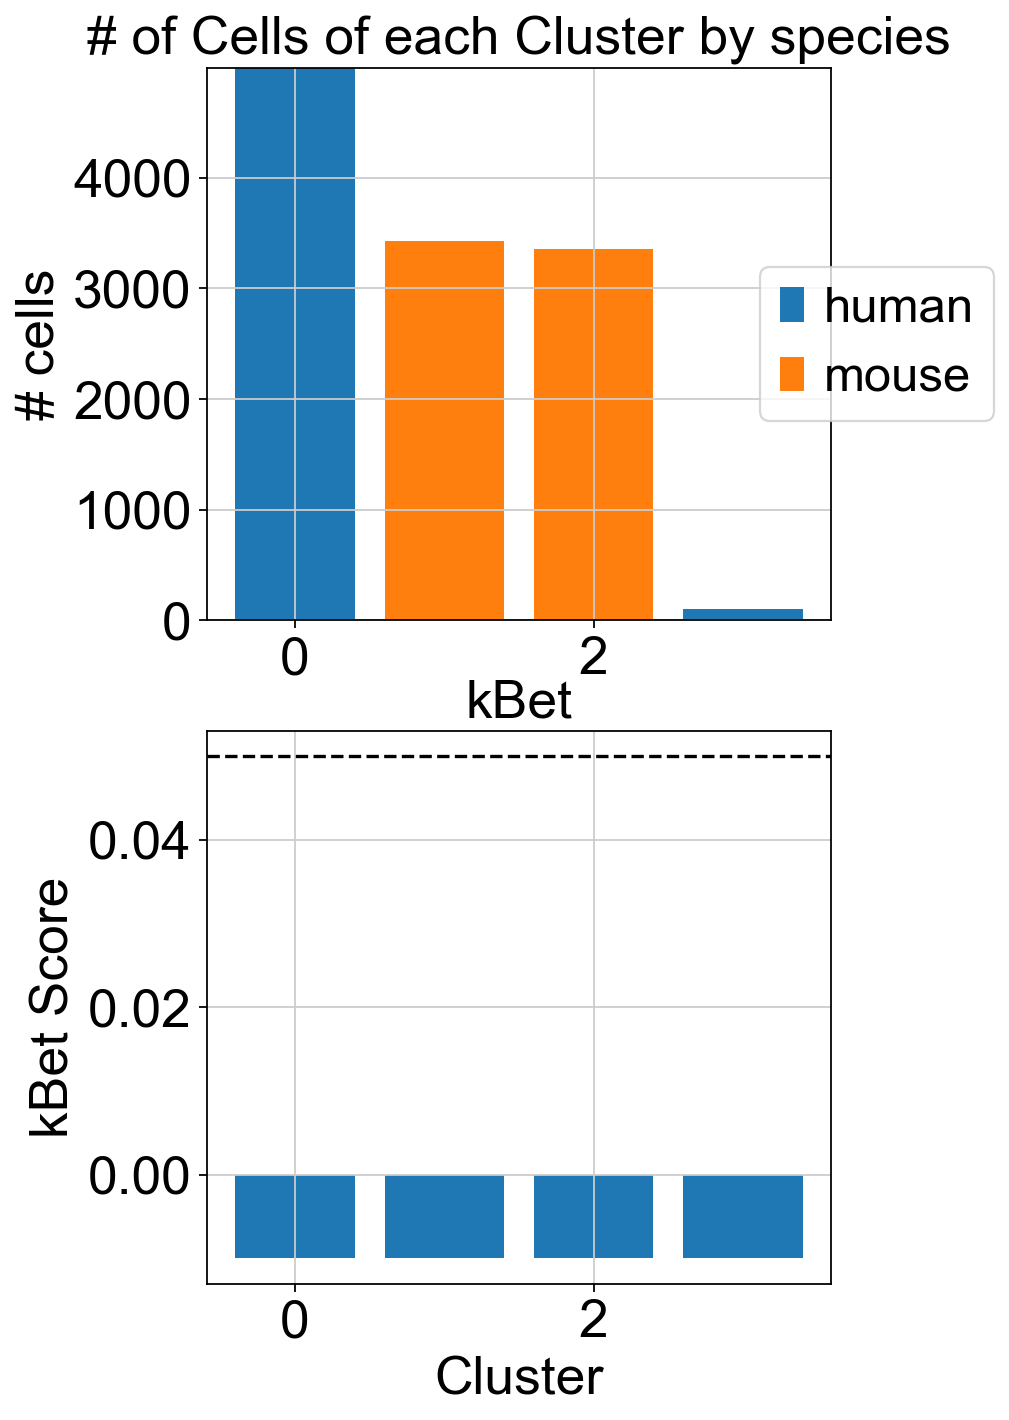

In [72]:
batchLabel="species"
umapKey = "norm"
neighborsKey = "norm"
tr.testClustAndStats(adata, umapKey = umapKey, neighborsKey=neighborsKey, pcaRep="X_pca", 
					cellLabel="cellState", batchLabel="species", 
					numOutLayer=40, outClustStatDir=None,res=0.2)

In [73]:
import bbknn

In [74]:
batchLabel="species"
cellLabel = "cellState"
umapKey = "BBKNN"
neighborsKey = "BBKNN"
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_pca", key_added=umapKey)
sc.external.pp.bbknn(adata, batch_key=batchLabel, use_rep="X_pca")#, neighbors_within_batch=3, n_pcs=50)  # running bbknn 1.3.6
sc.tl.umap(adata)


computing neighbors
    finished: added to `.uns['BBKNN']`
    `.obsp['BBKNN_distances']`, distances for each pair of neighbors
    `.obsp['BBKNN_connectivities']`, weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


running Leiden clustering
    finished: found 6 clusters and added
    'BBKNN', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


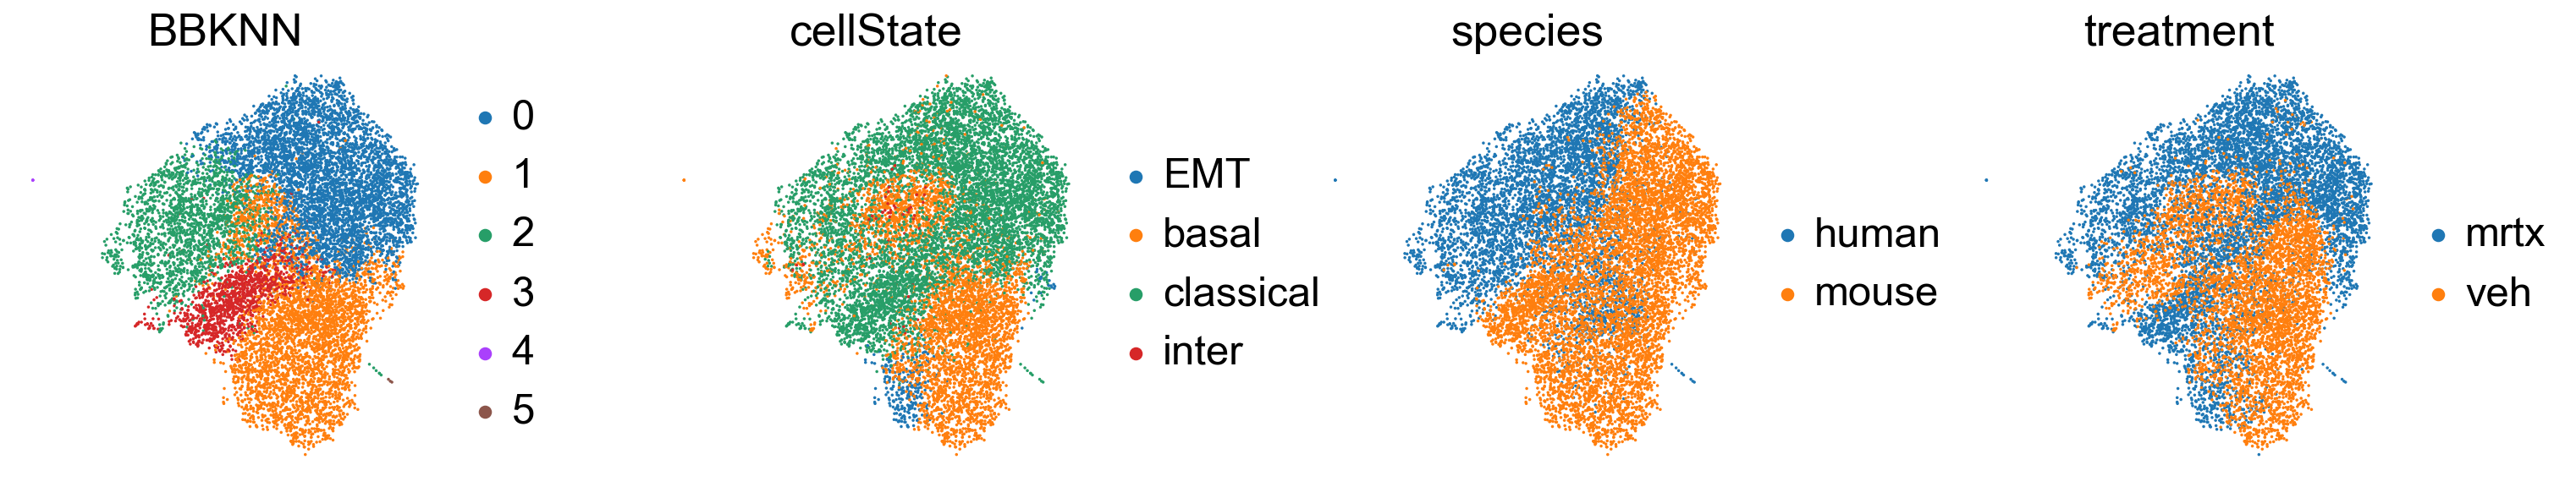

In [75]:
sc.tl.leiden(adata, resolution=0.2, key_added=neighborsKey)
sc.pl.umap(adata, color = [neighborsKey,cellLabel,batchLabel,"treatment"],ncols=4, wspace=0.4)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
running Leiden clustering
    finished: found 6 clusters and added
    'BBKNN', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'BBKNN', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'BBKNN', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'BBKNN', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'BBKNN', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: fo

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing neighbors


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished: added to `.uns['leiden46']`
    `.obsp['leiden46_distances']`, distances for each pair of neighbors
    `.obsp['leiden46_connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    finished: added to `.uns['leiden46']`
    `.obsp['leiden46_distances']`, distances for each pair of neighbors
    `.obsp['leiden46_connectivities']`, weighted adjacency matrix (0:00:00)


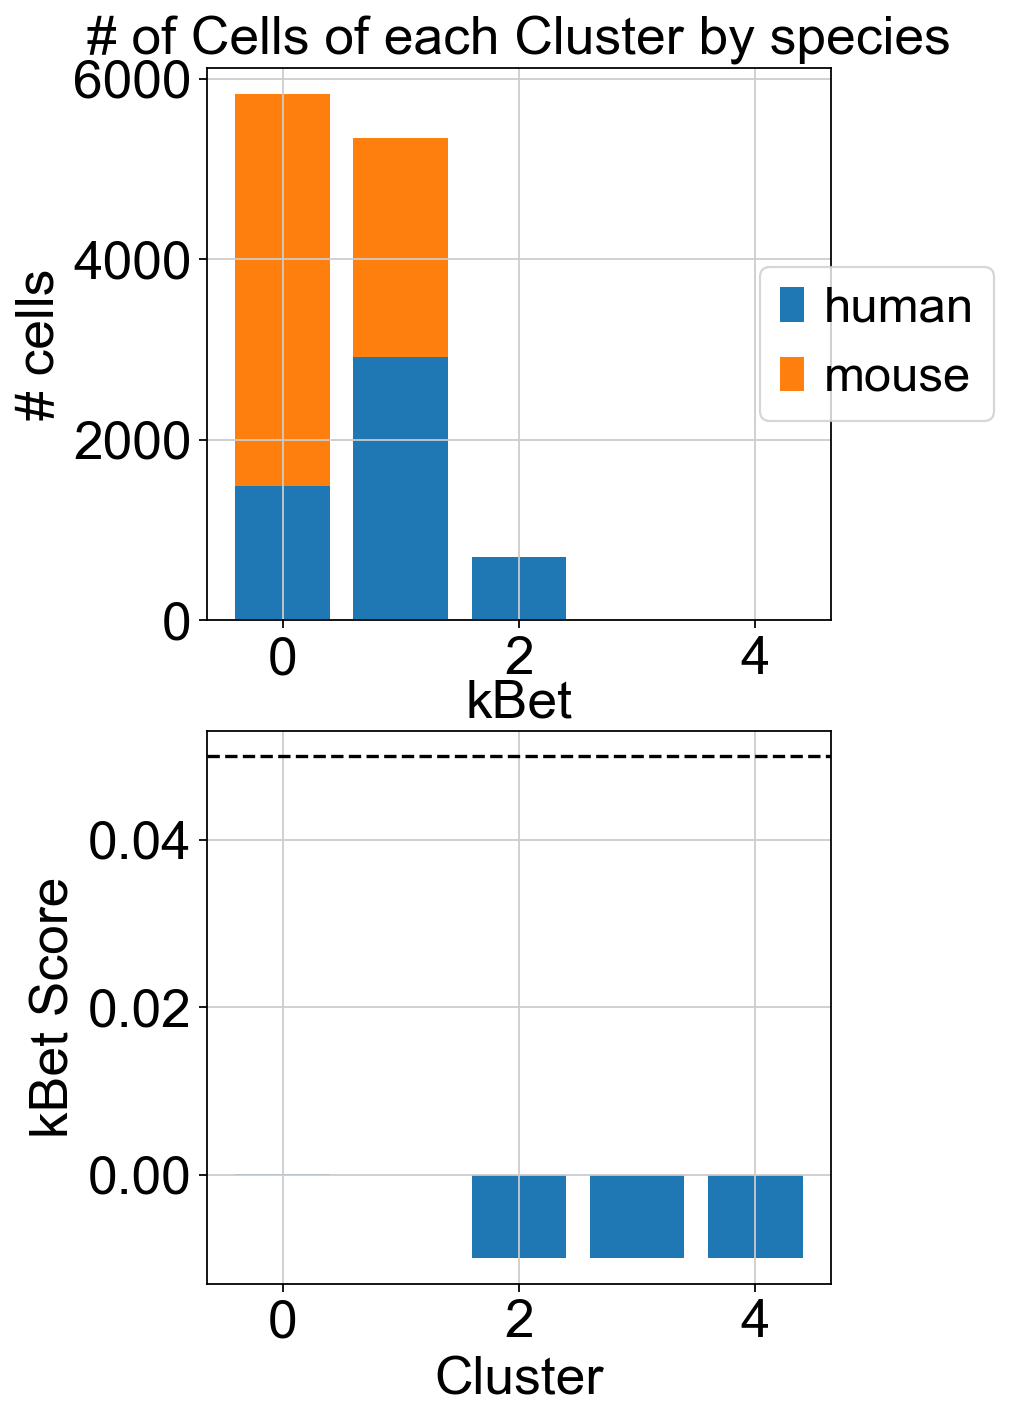

In [76]:
tr.testClustAndStats(adata, umapKey = None, neighborsKey=neighborsKey, pcaRep="X_pca", 
					cellLabel="cellState", batchLabel="species", 
					numOutLayer=40, outClustStatDir=None,res=0.2)

In [77]:
import harmonypy

In [78]:
batchLabel="species"
pcaRep = "X_pca_harmony"
umapKey = "harmony"
neighborsKey = "harmony"

sc.external.pp.harmony_integrate(adata, key=batchLabel)  #has to be str
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=50, use_rep=pcaRep, key_added=umapKey)
sc.tl.umap(adata, neighbors_key = umapKey)

2024-04-17 12:37:03,320 - harmonypy - INFO - Iteration 1 of 10
2024-04-17 12:37:05,165 - harmonypy - INFO - Iteration 2 of 10
2024-04-17 12:37:07,107 - harmonypy - INFO - Converged after 2 iterations


computing neighbors
    finished: added to `.uns['harmony']`
    `.obsp['harmony_distances']`, distances for each pair of neighbors
    `.obsp['harmony_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


running Leiden clustering
    finished: found 4 clusters and added
    'harmony', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


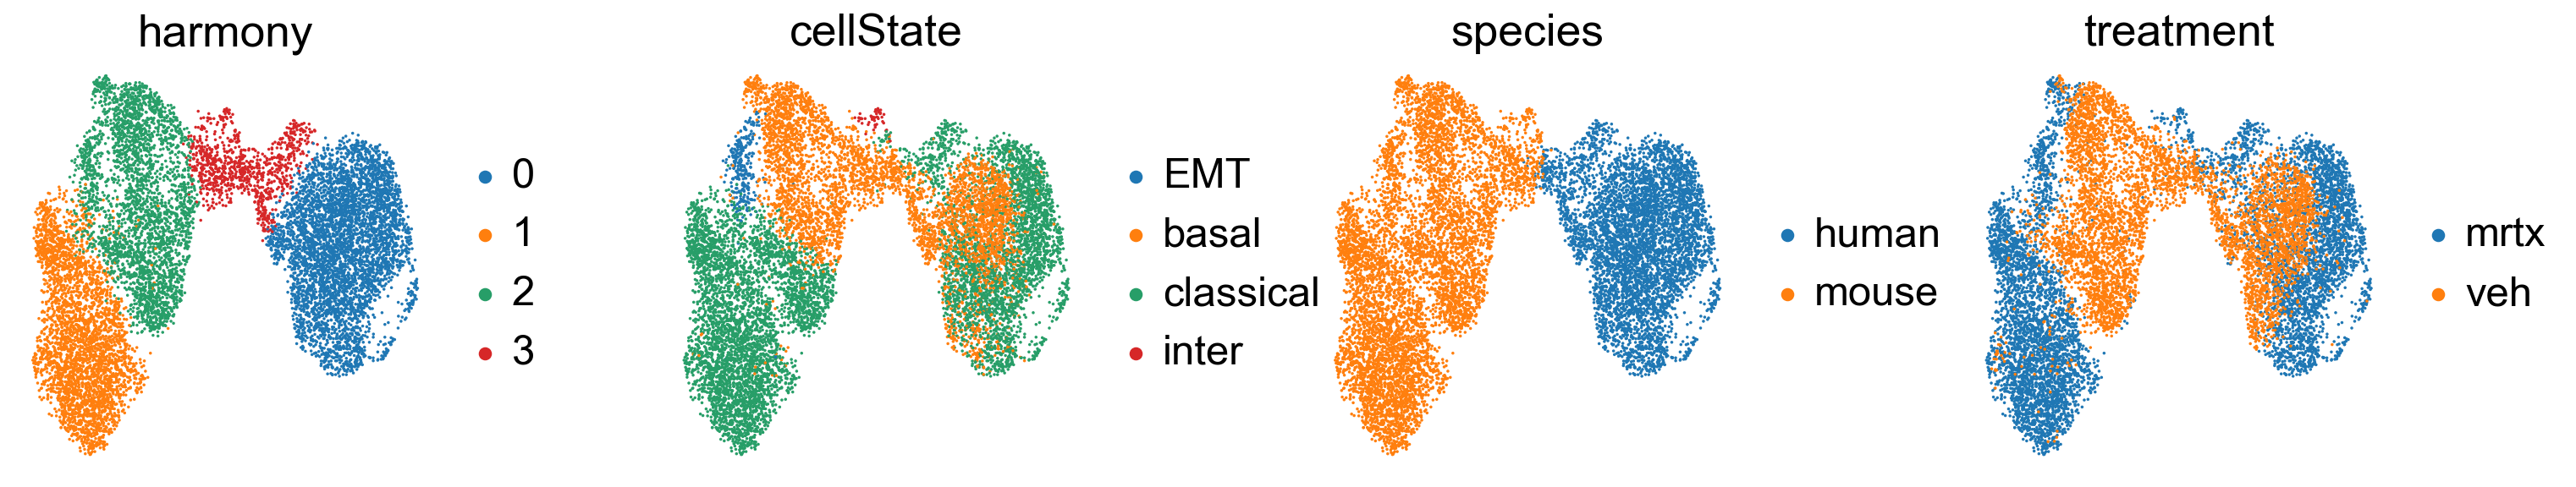

In [79]:
sc.tl.leiden(adata, resolution=0.2, key_added = neighborsKey, neighbors_key = umapKey)
sc.pl.umap(adata, color = [neighborsKey,cellLabel,batchLabel,"treatment"],neighbors_key = umapKey,ncols=4, wspace=0.4)

computing neighbors
    finished: added to `.uns['harmony']`
    `.obsp['harmony_distances']`, distances for each pair of neighbors
    `.obsp['harmony_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 3 clusters and added
    'harmony', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'harmony', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'harmony', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'harmony', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'harmony', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clusterin

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing neighbors


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished: added to `.uns['leiden46']`
    `.obsp['leiden46_distances']`, distances for each pair of neighbors
    `.obsp['leiden46_connectivities']`, weighted adjacency matrix (0:00:00)


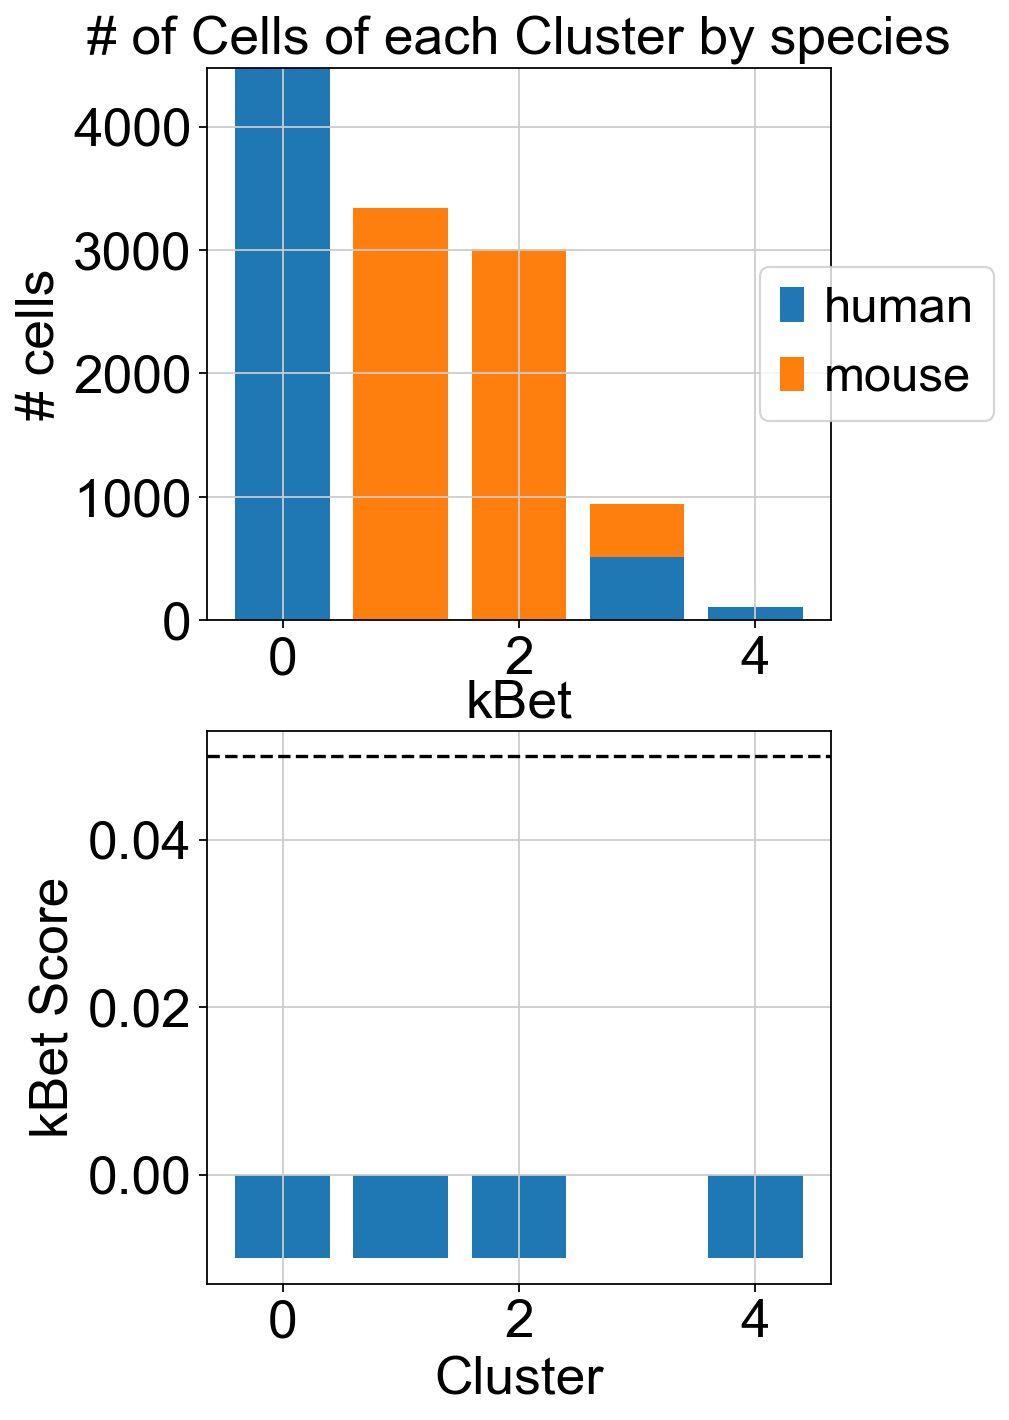

In [80]:
tr.testClustAndStats(adata, umapKey = umapKey, neighborsKey=neighborsKey, pcaRep=pcaRep, 
					cellLabel="cellState", batchLabel="species", 
					numOutLayer=40, outClustStatDir=None,res=0.2)

In [81]:
adata.write(mergedAdataFile)

In [82]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import time
import FuncVAEABC as tr
import AutoEncoder as ae
import Discriminator as dis 

In [63]:
inAdataFile = mergedAdataFile

outAdataFile = f'{writeDir}/{tissue}MousePdxMrtx_scVital.h5ad'
outVAEFile = f'{writeDir}/{tissue}MousePdxMrtx_scVialVae.pt'
outDiscFile = f'{writeDir}/{tissue}MousePdxMrtx_scVitalDisc.pt'
outLossDicFile = f'{writeDir}/{tissue}MousePdxMrtx_scVitalLoss.csv'
outCombFigFile = f'{writeDir}/{tissue}MousePdxMrtx_scVitalComb.png'

batchSize= 128
numEpoch = 64
learningRate = 1e-4
lastLayer = 10
inLayerDims = [1024,128]
inDiscLayer = 5
batchName = "species"
reconCoef = 15#try it later
klCoef = 0.1
discCoef = 1

In [64]:
inData, inLabels, batchSpecLabIndex = tr.getTrainLabel(mergedAdataFile, "", obsLabel=batchName)
#inData = tr.addUbiqGenes(inData)

#ldTrainDataLoader, ldValX, layer1Dim, numSpeices = tr.getDataLoader(inData, inLabels, batchSize, trainPer)
LabeledData, layer1Dim, numSpeices = tr.getDataLoader(inData, inLabels)
print(numSpeices)
layerDims = [layer1Dim] + inLayerDims + [lastLayer]
inDiscriminatorDims = [lastLayer, inDiscLayer]

#print(f"inAdataFile: {inAdataFile} outAdataFile: {outAdataFile} \n\
#	batchSize: {batchSize} numEpoch: {numEpoch} learningRate: {learningRate} \n\
#	layerDims: {layerDims} discriminatorDims: {inDiscriminatorDims} \n\
#	trainPer: {trainPer} batchName: {batchName}")

encoder = ae.Encoder(layerDims, numSpeices)
decoder = ae.Decoder(layerDims, numSpeices, geneIndexes = batchSpecLabIndex)
autoencoder = ae.EncoderDecoder(encoder, decoder)

discriminator =  dis.Discriminator(inDiscriminatorDims, numSpeices)

autoencoderOpt = torch.optim.Adam(params = autoencoder.parameters(), lr = learningRate)
discriminatorOpt = torch.optim.Adam(params = discriminator.parameters(), lr = learningRate)
	
reconstructionLossFunc = torch.nn.MSELoss()
discriminatorLossFunc = torch.nn.CrossEntropyLoss()

print(autoencoder)

reconCoefNew = reconCoef*(np.round(inData.shape[0]*inData.shape[1]/1000000,-1)/10+1)
print(f"reconCoef: {reconCoef} -> reconCoefNew: {reconCoefNew}")

#if(reconCoefNew != reconCoef):
#	for inFile in snakemake.output:
#		inFile = changeFileName(inFile, "reconCoef", reconCoefNew, pramSplit="_", valSplit = "~"):

startTrain = time.process_time() 

autoencoderOut, discriminator, lossDict = tr.trainVAEABC(autoencoder, autoencoderOpt, reconstructionLossFunc, 
													  discriminator, discriminatorOpt, discriminatorLossFunc,
													  LabeledData, batchSize, numEpoch, #ldTrainDataLoader 
													  reconCoef=reconCoefNew, klCoef=klCoef, discCoef=discCoef,
													  numSpeices=numSpeices, discTrainIter=5)

endTrain = time.process_time()
print(f"{(endTrain-startTrain)/60} mins")

autoencoderOut.eval()
encoderOut = autoencoderOut.getEncoder()
encoderOut.eval()

discriminator.eval()

LabOneHot = torch.reshape(F.one_hot(inLabels.to(torch.int64), num_classes=numSpeices).float(),(inData.shape[0], numSpeices))
labOneHotInData = torch.cat((inData, LabOneHot),axis=1)

allEncOut = encoderOut(labOneHotInData)
bLatent = allEncOut.detach().numpy()
reconData = autoencoderOut(labOneHotInData, inLabels, numSpeices).detach().numpy()

adata = sc.read(inAdataFile)
adata.obsm["X_pcAE"] = bLatent
adata.layers["recon"] = reconData

adata.write(outAdataFile)

2
EncoderDecoder(
  (encoder): Encoder(
    (hidden0): Sequential(
      (0): Linear(in_features=2173, out_features=1024, bias=True)
      (1): ReLU()
    )
    (hidden1): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): ReLU()
    )
    (mu): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
    (lnVar): Sequential(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (decoder): Decoder(
    (hidden0): Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): ReLU()
    )
    (hidden1): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): ReLU()
    )
    (hidden2): Sequential(
      (0): Linear(in_features=1024, out_features=2171, bias=True)
    )
  )
)
reconCoef: 25 -> reconCoefNew: 100.0
7.8812867666666655 mins


In [65]:
adata

AnnData object with n_obs × n_vars = 11879 × 2171
    obs: 'species', 'GMM', 'treatment', 'cellState', 'decoupler', 'PCA'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'PCA_colors', 'cellState_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'species_colors', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_pcAE'
    varm: 'PCs'
    layers: 'counts', 'recon'
    obsp: 'connectivities', 'distances'

In [66]:
umapKey = "scVital"
neighborsKey = "scVital"
cellLabel="cellState"
batchLabel="species"
sc.pp.neighbors(adata, n_pcs=10, use_rep="X_pcAE", key_added=umapKey)
sc.tl.umap(adata, neighbors_key = umapKey)


computing neighbors
    finished: added to `.uns['scVital']`
    `.obsp['scVital_distances']`, distances for each pair of neighbors
    `.obsp['scVital_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


running Leiden clustering
    finished: found 3 clusters and added
    'scVital', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


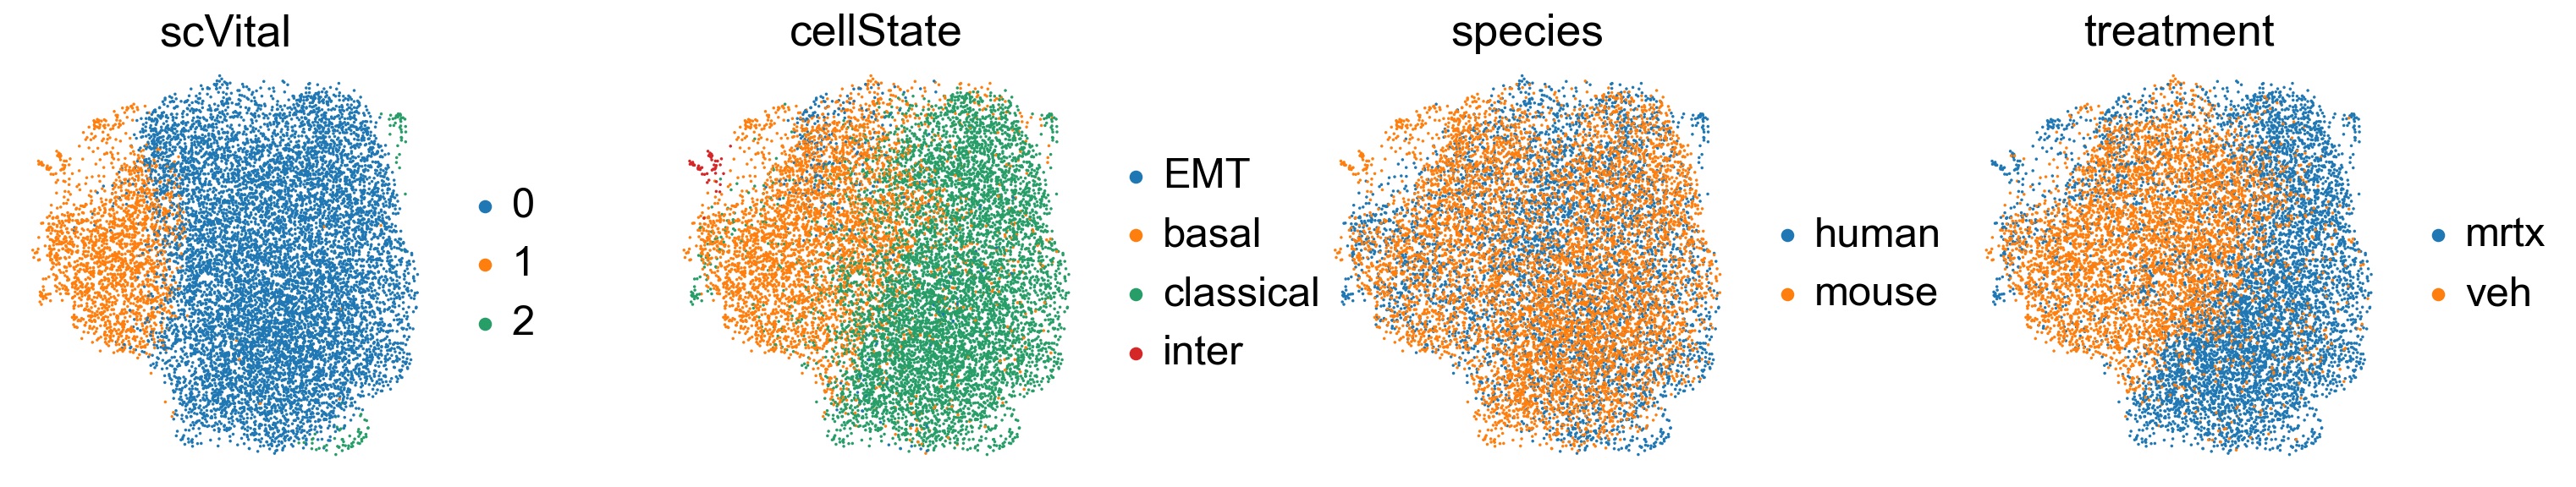

In [67]:
sc.tl.leiden(adata, resolution=0.2, key_added = neighborsKey, neighbors_key = umapKey)
sc.pl.umap(adata, color = [neighborsKey,cellLabel,batchLabel,"treatment"],neighbors_key = umapKey, wspace=0.4)

computing neighbors
    finished: added to `.uns['scVital']`
    `.obsp['scVital_distances']`, distances for each pair of neighbors
    `.obsp['scVital_connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 3 clusters and added
    'scVital', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'scVital', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'scVital', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 6 clusters and added
    'scVital', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'scVital', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clusterin

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


computing neighbors


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


    finished: added to `.uns['leiden46']`
    `.obsp['leiden46_distances']`, distances for each pair of neighbors
    `.obsp['leiden46_connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    finished: added to `.uns['leiden46']`
    `.obsp['leiden46_distances']`, distances for each pair of neighbors
    `.obsp['leiden46_connectivities']`, weighted adjacency matrix (0:00:00)
computing neighbors
    finished: added to `.uns['leiden46']`
    `.obsp['leiden46_distances']`, distances for each pair of neighbors
    `.obsp['leiden46_connectivities']`, weighted adjacency matrix (0:00:00)


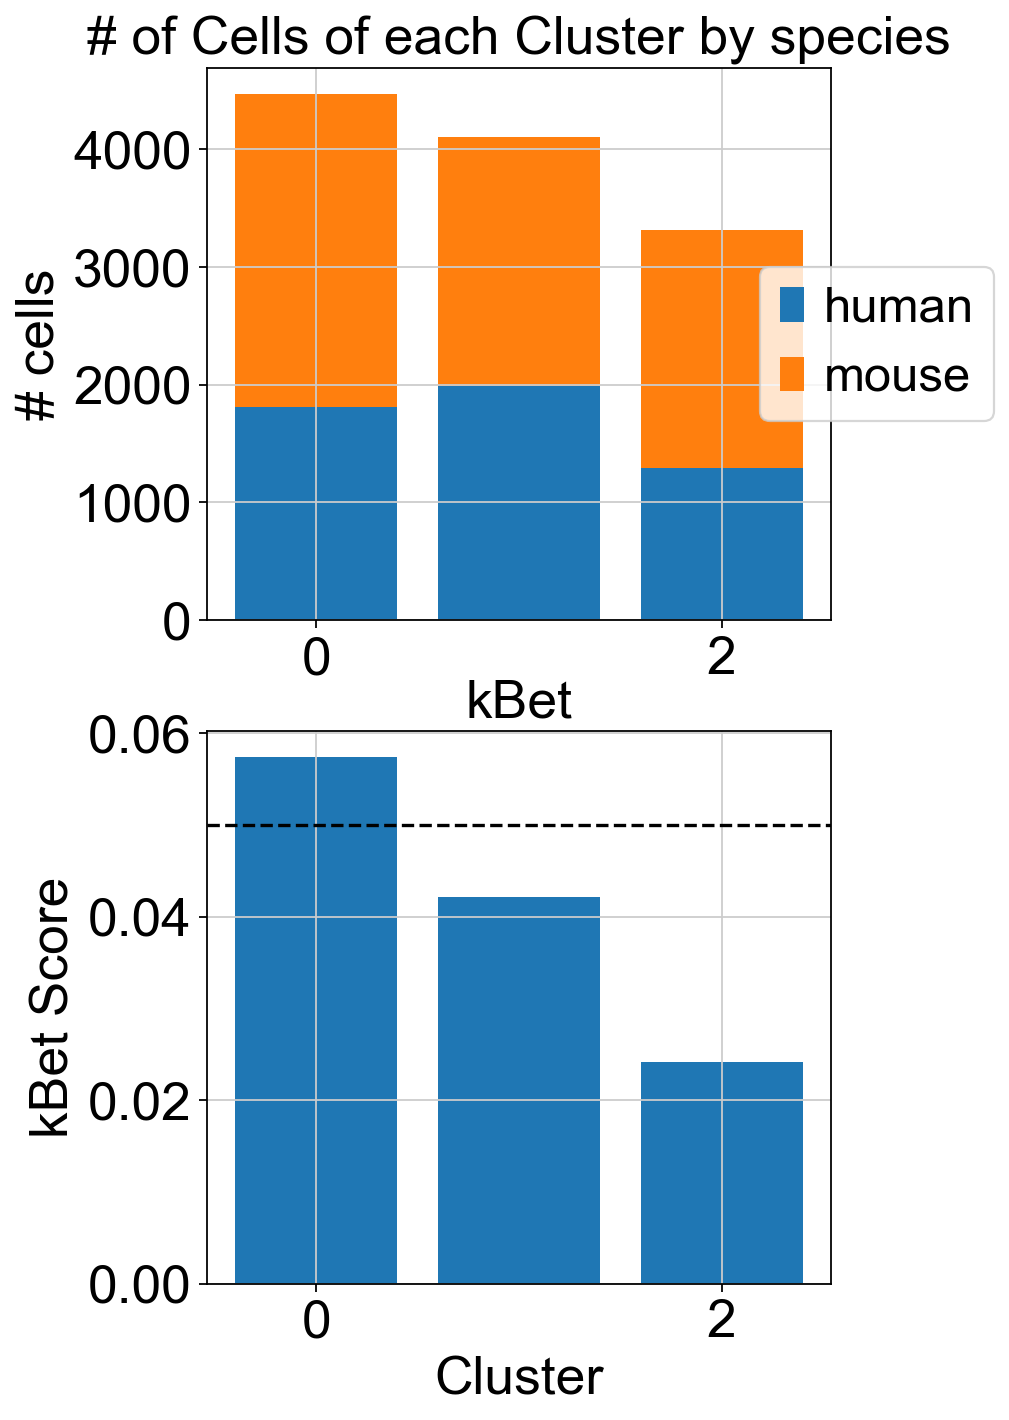

In [68]:
tr.testClustAndStats(adata, umapKey = umapKey, neighborsKey="scVital", pcaRep="X_pcAE", 
					cellLabel="cellState", batchLabel="species", 
					numOutLayer=10, outClustStatDir="write/",res=0.2)

In [69]:
adata

AnnData object with n_obs × n_vars = 11879 × 2171
    obs: 'species', 'GMM', 'treatment', 'cellState', 'decoupler', 'PCA', 'scVital'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'PCA_colors', 'cellState_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'species_colors', 'treatment_colors', 'umap', 'scVital', 'scVital_colors'
    obsm: 'X_pca', 'X_umap', 'X_pcAE'
    varm: 'PCs'
    layers: 'counts', 'recon'
    obsp: 'connectivities', 'distances', 'scVital_distances', 'scVital_connectivities'

In [83]:
from sklearn import metrics
lat = ['scVital', 'BBKNN', 'harmony', 'scVI', "PCA"]
df = pd.DataFrame(np.zeros(len(lat)),index=lat,columns=["PDAC"])
for l in lat:
    df.loc[l]= metrics.fowlkes_mallows_score(adata.obs.cellState,adata.obs[l])
print(df)

KeyError: 'scVital'

In [ ]:
numDatas = df.shape[0]
dataNames = df.index

numInteg = df.shape[1]
integNames = df.columns

index = np.arange(numInteg)
width = 1/(numDatas+1)

bars = np.empty(numDatas, dtype=object)
fig = plt.figure()
ax = fig.add_subplot(111)
for i, data in enumerate(dataNames):
    dataVals = np.array(df.loc[data,:])
    bar = ax.bar(index + width*i, dataVals, width)#, color = 'r')
    bars[i] = bar

ax.set_xlabel("Integration")
ax.set_ylabel("FM Score")
ax.set_title("PDAC")
ax.set_xticks(index + (width*((numDatas-1)/2)), integNames, rotation=80)
legend = ax.legend(bars, dataNames, loc='center right',bbox_to_anchor=(1.7,0.5))
fig.savefig(f'write/PDAC_barByInteg.svg', bbox_inches='tight')

In [ ]:
import scvi
from scvi.model.utils import mde

In [ ]:
umapKey = "scVI"
neighborsKey = "scVI"
cellLabel="cellState"
batchLabel="species"
pcaRep = "X_scVI"

scvi.model.SCVI.setup_anndata(adata, batch_key=batchLabel, layer="counts")
scviVAE = scvi.model.SCVI(adata, n_layers=2, n_latent=10, gene_likelihood="nb")
scviVAE.train(max_epochs=100, early_stopping=True)
scViLatent = scviVAE.get_latent_representation()
adata.obsm[pcaRep] = scViLatent

In [ ]:
umapKey = "scVI"
neighborsKey = "scVI"
cellLabel="cellState"
batchLabel="species"
pcaRep = "X_scVI"
sc.pp.neighbors(adata, n_pcs=10, use_rep=pcaRep, key_added=umapKey)
sc.tl.umap(adata, neighbors_key = umapKey)


In [ ]:
sc.tl.leiden(adata, resolution=0.15, key_added = neighborsKey, neighbors_key = umapKey)
sc.pl.umap(adata, color = [neighborsKey,cellLabel,batchLabel,"treatment"], neighbors_key=umapKey, wspace=0.4)

In [ ]:
tr.testClustAndStats(adata, umapKey = umapKey, neighborsKey=neighborsKey, pcaRep=pcaRep, 
					cellLabel="cellState", batchLabel="species", 
					numOutLayer=10, outClustStatDir="write/",res=0.15)

In [ ]:
adata.obs

In [ ]:
tr.vizMetricsDF(metricDf, metricFile)

In [ ]:
latents=['X_pcAE', 'X_pca', 'X_umap', 'X_pca_harmony', 'X_scVI']

In [ ]:
try:
    print(adata.uns.cellTypes1)
except:
    hlab, mlab, pairs = tr.simpleCasePairsAdata(adata,"cellState")
    adata.uns["cellTypes1"] = hlab
    adata.uns["cellTypes2"] = mlab 
    adata.uns["pairs"] = pairs

print(adata)

In [ ]:
for lat in latents:
    print(lat)
    tr.heirSimi(adata, lat, "cellState", 
         np.append(adata.uns["cellTypes1"] , adata.uns["cellTypes2"]))

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=8, svd_solver='arpack')
pca.fit(adata.obsm["X_pcAE"])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.17153351 0.14229581 0.12906101 0.11327464 0.10369511 0.09342636
 0.07508778 0.06773949]
[113.27541  103.1709    98.25591   92.05079   88.072495  83.598
  74.94554   71.18395 ]


In [61]:
vitalPca = pca.fit_transform(adata.obsm["X_pcAE"])

In [62]:
adata.obsm["X_pca"]

array([[ 11.054243  ,  -0.14165612,   2.0992846 , ...,   0.11641964,
         -1.8632667 ,  -0.21223165],
       [ 12.185939  ,   1.8956004 ,   6.4566917 , ...,  -0.02217649,
         -0.30741268,  -0.44349813],
       [  7.0674148 ,  -1.0712832 ,  -2.6216035 , ...,   1.0563406 ,
          0.6366856 ,   0.3122287 ],
       ...,
       [ -6.2214856 ,   4.6002536 ,  -7.319735  , ...,  -0.46629295,
         -0.66459566,  -1.2815299 ],
       [ -4.0064836 ,   1.5953803 , -12.389263  , ...,   0.6716971 ,
         -0.09178731,   0.47402272],
       [ -8.423934  ,  -4.8879476 ,  -1.0211848 , ...,   0.56174916,
          0.5899959 ,   0.53280175]], dtype=float32)

In [63]:
treatColor = {"veh":1,"mrtx":0}
treatColors = [adata.uns["treatment_colors"][treatColor[i]] for i in adata.obs["treatment"]]

csColor = dict(zip(adata.obs.cellState.cat.categories,range(4)))
csColors = [adata.uns["cellState_colors"][csColor[i]] for i in adata.obs["cellState"]]

sColor = dict(zip(adata.obs.species.cat.categories,range(3)))
sColors = [adata.uns["species_colors"][sColor[i]] for i in adata.obs["species"]]

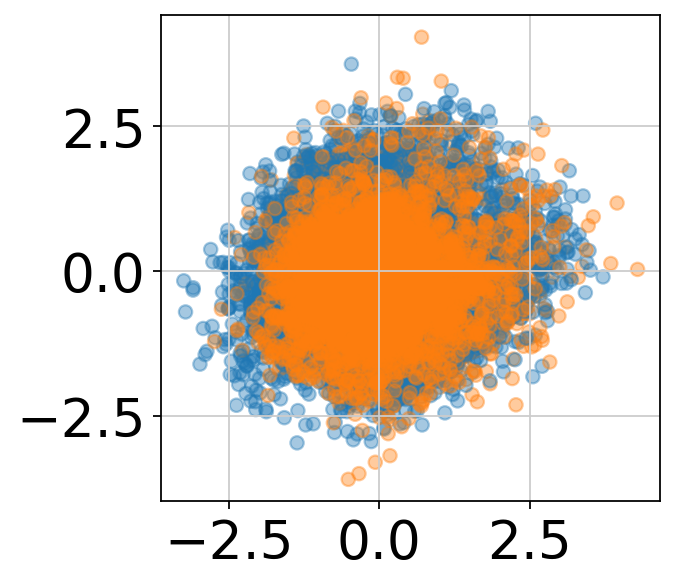

In [64]:
plt.scatter(vitalPca[:,0],vitalPca[:,1],c=treatColors,alpha=0.4)

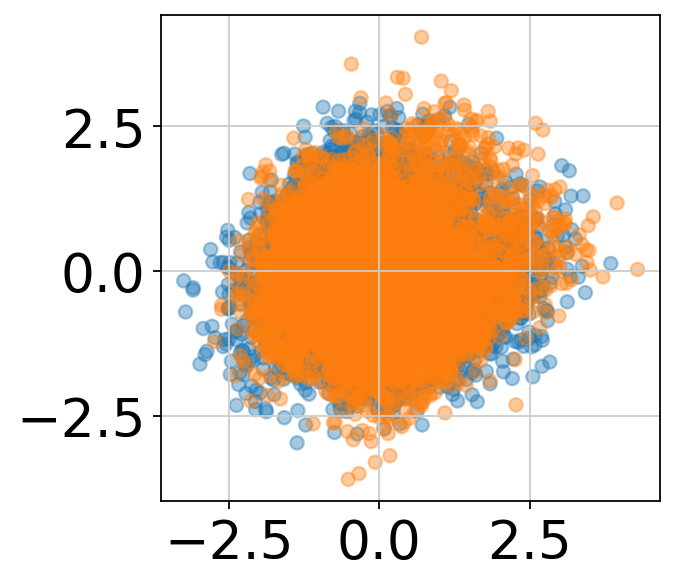

In [65]:
plt.scatter(vitalPca[:,0],vitalPca[:,1],c=sColors,alpha=0.4)

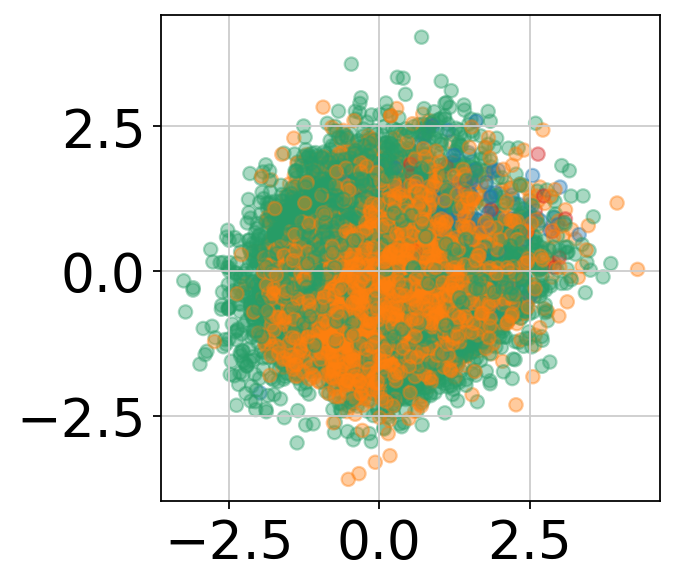

In [66]:
plt.scatter(vitalPca[:,0],vitalPca[:,1],c=csColors,alpha=0.4)

In [67]:
sum(pca.explained_variance_ratio_)#[:-2])


0.8961137309670448

In [68]:
adata.write(mergedAdataFile)

In [8]:
adata = sc.read(mergedAdataFile)
adata

AnnData object with n_obs × n_vars = 11879 × 2171
    obs: 'species', 'GMM', 'treatment', 'cellState', 'decoupler', 'leiden', 'scVital_leiden', 'scVital'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mt'
    uns: 'ae', 'cellState_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'scVital_colors', 'scVital_umap', 'species_colors', 'treatment_colors', 'umap'
    obsm: 'X_pcAE', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'recon'
    obsp: 'ae_connectivities', 'ae_distances', 'connectivities', 'distances', 'scVital_umap_connectivities', 'scVital_umap_distances'

In [9]:
def testClustAndStats(adata, umapKey, neighborsKey, pcaRep, 
					  cellLabel, batchLabel, numOutLayer, outClustStatDir, res=None,
					  nNeighborsUMAP=15, nNeighborsKbet=45, inters=25, cellsPerIter=30,
					  save=True):
	sc.set_figure_params(scanpy=True, dpi_save=300, fontsize=24, format='svg', frameon=False,transparent=True)

	batchUmapFilename = f"_{batchLabel}_{neighborsKey}"
	neighUmapFilename = f"_leiden_{neighborsKey}"
	trueUmapFilename = f"_{cellLabel}_{neighborsKey}"
	if(not save):
		batchUmapFilename, neighUmapFilename, trueUmapFilename = False, False, False

	#adata.uns[f'{batchLabel}_colors'] = ['#FF7F50','#76EEC6']
	if (neighborsKey=="BBKNN"):
		#startTrain = time.process_time() 
		sc.external.pp.bbknn(adata, batch_key=batchLabel, use_rep="X_pca")#, neighbors_within_batch=4, n_pcs=numOutLayer)#, key_added=umapKey)
		#endTrain = time.process_time()
		#scale = pd.DataFrame(np.array([[adata.X.size, endTrain-startTrain]]), columns=["Size", "BBKNN"])
		#scale.to_csv(f"{outClustStatDir}scale_BBKNN.csv")
	else:
		sc.pp.neighbors(adata, n_neighbors=nNeighborsUMAP, n_pcs=numOutLayer, use_rep=pcaRep, key_added=umapKey)

	sc.tl.umap(adata, neighbors_key = umapKey)

	if(cellLabel == "None"):
		cellLabel = np.nan
		trueUmapFilename = False

	#res = 0.5
	#maxAri = 0
	if(not pd.isna(cellLabel) and res == None):
		#print(" \t YES TRUE CLUSTERING")
		nwClust = 0 #new cluster
		ctClust = len(adata.obs[cellLabel].cat.categories) #true cluster
		i = 0
		while(True):
			sc.tl.leiden(adata, resolution=res, key_added = neighborsKey, neighbors_key = umapKey)
			#newARI = metrics.adjusted_rand_score(adata.obs[cellLabel], adata.obs[neighborsKey])
			nwClust = len(adata.obs[neighborsKey].cat.categories)
			#print(f"\n\t {neighborsKey} {i} {res} {nwClust} {ctClust}\n")
			if(nwClust - ctClust == 0 or res == 0):
				break
			elif(np.abs(nwClust - ctClust) <= 1 and i > 8):
				break
			elif(i > 10):
				break

			if(nwClust - ctClust > 0):
				res = res - 0.05
			else:
				res = res + 0.05
			i += 1
		
		#print(f"{i} {res} {nwClust} {ctClust}")
		sc.pl.umap(adata, color = [cellLabel], ncols = 1, show=False, save=trueUmapFilename, legend_fontsize="xx-small")#palette="tab10",
		metricDF = tr.getClusterMetricDF(labels_true = adata.obs[cellLabel], labels = adata.obs[neighborsKey], neighborsKey=neighborsKey)
		metricDF.to_csv(f"{outClustStatDir}metrics_{neighborsKey}.csv")
	else:
		sc.tl.leiden(adata, resolution = res, key_added = neighborsKey, neighbors_key = umapKey)
		
	#pdb.set_trace()
	sc.pl.umap(adata, color = [batchLabel], ncols = 1, show=False, save=batchUmapFilename, legend_fontsize="xx-small") #, palette=colorDict,
	sc.pl.umap(adata, color = [neighborsKey], ncols = 1, show=False, save=neighUmapFilename, legend_fontsize="xx-small")#palette="Set2",
	
	aeStats = tr.getClustMetrics(adata, neighborsKey, batchID = batchLabel,
								numNeighbors = nNeighborsKbet, 
								interations = inters, 
								cellsPerIter = cellsPerIter, 
								rep = pcaRep,
								n_pcs = numOutLayer)
	aeStats.to_csv(f"{outClustStatDir}stats_{neighborsKey}.csv")

	clustBatch = adata.obs[[neighborsKey,batchLabel]]
	tr.vizFracNkBet(clustBatch=clustBatch, neighborsKey=neighborsKey, label=batchLabel, kbetScore=aeStats, outDir=outClustStatDir)


	

In [119]:
dataDirs = "write/"
print(dataDirs)
datas = []#[dataDir.split("~")[1] for dataDir in os.listdir(outDir)]
for dataDir in os.listdir(outDir):
    if("~" in dataDir):
        datas = datas+[dataDir.split("~")[1]]
        
clutNameSet = set()
print(datas)
for dataDir in os.listdir(outDir): #for every dataset
    if("~" in dataDir):
        for infoDir in os.listdir(os.path.join(outDir,dataDir)):#for every out file
            if(os.path.isdir(os.path.join(outDir,dataDir,infoDir)) and (not infoDir=="figures")):
                for file in os.listdir(os.path.join(outDir,dataDir,infoDir,"clusters")):
                    if(".csv" in file):
                        name = file.split(".")[0]
                        clutNameSet.add(f"{name}")
                break

clutNameList= list(clutNameSet)

fmDf = pd.DataFrame(np.zeros((len(datas),len(clutNameList))),
                 index=datas,
                 columns=clutNameList)
ariDf = pd.DataFrame(np.zeros((len(datas),len(clutNameList))),
                 index=datas,
                 columns=clutNameList)
scaleDf = pd.DataFrame(np.zeros((len(datas),1+len(clutNameList))),
                 index=datas,
                 columns=["Size"]+clutNameList)

conDict = {"FM":fmDf,
           "ARI":ariDf,
           "scale":scaleDf}

for dataDir in os.listdir(outDir): #for every dataset
    if("~" in dataDir):
        dataName = dataDir.split("~")[1]
        for infoDir in os.listdir(os.path.join(outDir,dataDir)):#for every out file
            if(os.path.isdir(os.path.join(outDir,dataDir,infoDir)) and (not infoDir=="figures")):
                metricDir = os.path.join(outDir,dataDir,infoDir,"figures","")
                figsFiles = np.array(os.listdir(metricDir))
                metricsFilesBool = np.array([".csv" in figsFile for figsFile in figsFiles])
                metricsFiles = figsFiles[metricsFilesBool]
                for metFile in metricsFiles:
                    fullMetFile = metricDir + metFile
                    infoDF = pd.read_csv(fullMetFile, index_col=0)
                    if("scale" in fullMetFile):
                        conDict["scale"].loc[dataName,["Size", infoDF.columns[1]]] = infoDF.iloc[0,:]
                    elif("metrics" in fullMetFile):
                        integ = infoDF.columns[0]
                        for metric in infoDF.index:
                            conDict[metric].loc[dataName,integ] = infoDF.loc[metric,integ]

print(conDict)

tr.plotMetricBarByData(conDict["ARI"], label="ARI", outDir=outDir)
tr.plotMetricBarByData(conDict["FM"], label="FM", outDir=outDir)

tr.plotMetricBarByInteg(conDict["ARI"], label="ARI", outDir=outDir)
tr.plotMetricBarByInteg(conDict["FM"], label="FM", outDir=outDir)

tr.plotScale(conDict["scale"], outDir=outDir)

print("fin")


False